In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 10.1 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 216, done.
remote: Counting objects:

---

In [ ]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [ ]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-151b9d639ad9>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [ ]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Experiment_section-1", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2 V1", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'I3D embeddings',
    # model training configs
    "lr": 0.0001,
    "class_alpha": 0.2,
    "n_epochs": 20,
    "batch_size": 64,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "seq_len": 5,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8
}

In [ ]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [ ]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2Reader(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [ ]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [ ]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [ ]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True,
                            dropout=0.1)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

---

In [ ]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [ ]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [ ]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [ ]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def shuffledTripletLoss(pred_feat, sem_space, y, bs=32, loss_fn=nn.TripletMarginLoss(margin=0.1, p=2, reduction='none')):
    anchor_feat = sem_space[y, ...]
    neg_feat = torch.concat([anchor_feat[bs//2:, ...], anchor_feat[:bs//2, ...]], dim=0).squeeze()
    pos_feat = anchor_feat.squeeze()

    neg_y = torch.concat([y[bs//2:], y[:bs//2]])
    y_mask = (y!=neg_y).long()

    output_arr = loss_fn(pred_feat, pos_feat, neg_feat)
    masked_arr = torch.multiply(output_arr, y_mask)

    output = masked_arr.mean()
    return output

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [ ]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output, targets.squeeze(), random_selected_feat, loss_fn =loss_module['class'] )
                feat_loss = shuffledTripletLoss(feat_output, random_selected_feat, targets, loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = (1-loss_alpha)*feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [ ]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = shuffledTripletLoss(feat_output, random_selected_feat, targets, loss_fn=loss_module["constrastive"])
            
            #loss = cross_entropy_loss
            loss = (1-loss_alpha)*feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [ ]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [ ]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-125


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.074



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.078



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.094



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.161



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.192



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.234



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.280



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.238



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.216



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.228



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.228



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.228



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.233



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.232



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.227



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.238



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.253



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.293



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.309



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.322



unseen:   0%|          | 0/87 [00:00<?, ?batch/s]

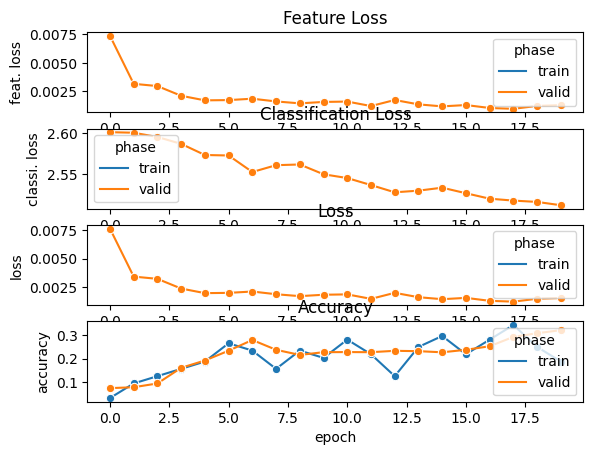

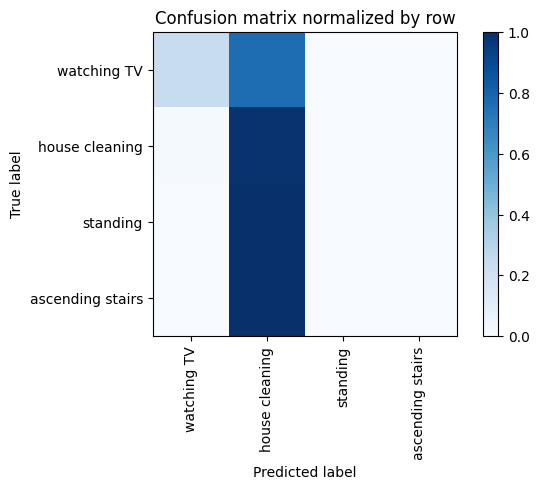

Overall accuracy: 0.359

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.000      0.000      0.000      0.331       1842|	 house cleaning: 0.998,	watching TV: 0.002,	ascending stairs: 0.000,	
  house cleaning       0.338      0.988      0.503      0.328       1828|	 watching TV: 0.012,	ascending stairs: 0.000,	
ascending stairs       0.000      0.000      0.000      0.193       1073|	 house cleaning: 1.000,	standing: 0.000,	
     watching TV       0.886      0.236      0.373      0.148        825|	 house cleaning: 0.764,	ascending stairs: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.242      0.359      0.221        1.0       5568|	      

{'accuracy': 0.359375, 'precision': 0.30601499286054257, 'recall': 0.3060821563556793, 'f1': 0.21913755580803634, 'samples': 5568, 'loss': 1026.3269891738892, 'feat. loss': 1025.5668668746948, '

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.027



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.029



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.063



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.177



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.190



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.201



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.202



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.207



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.209



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.207



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.210



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.210



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.211



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.209



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.208



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.208



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.207



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.208



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.208



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.209



unseen:   0%|          | 0/86 [00:00<?, ?batch/s]

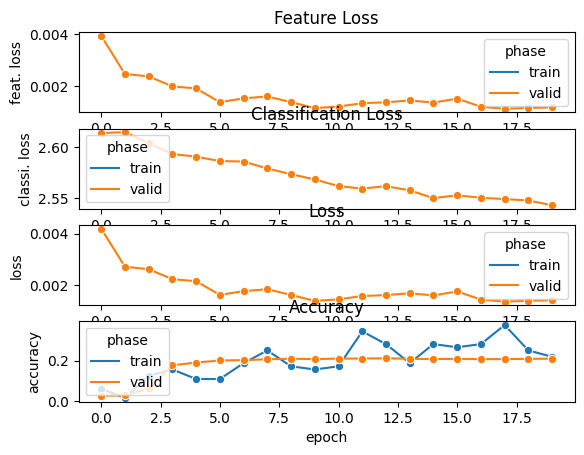

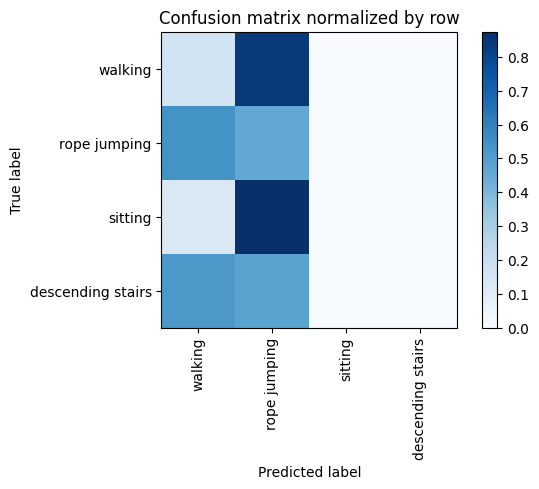

Overall accuracy: 0.106

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.280      0.161      0.204      0.422       2322|	 rope jumping: 0.839,	descending stairs: 0.000,	
          sitting       0.000      0.000      0.000      0.325       1789|	 rope jumping: 0.874,	walking: 0.126,	descending stairs: 0.000,	
descending stairs       0.000      0.000      0.000      0.171        939|	 walking: 0.521,	rope jumping: 0.479,	
     rope jumping       0.050      0.458      0.090      0.082        454|	 walking: 0.542,	descending stairs: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.122      0.106      0.094        1.0       5504|	      

{'accuracy': 0.10555959302325581, 'precision': 0.08242202303153108, 'recall': 0.15469679032582423, 'f1': 0.07351247827855215, 'samples': 5504, 'loss': 2332.0636024475098, 'feat. loss': 2331.2999324798

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.168



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.226



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.275



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.249



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.242



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.236



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.234



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.233



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.234



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.233



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.235



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.232



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.235



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.235



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.236



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.234



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.233



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.234



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.234



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.234



unseen:   0%|          | 0/111 [00:00<?, ?batch/s]

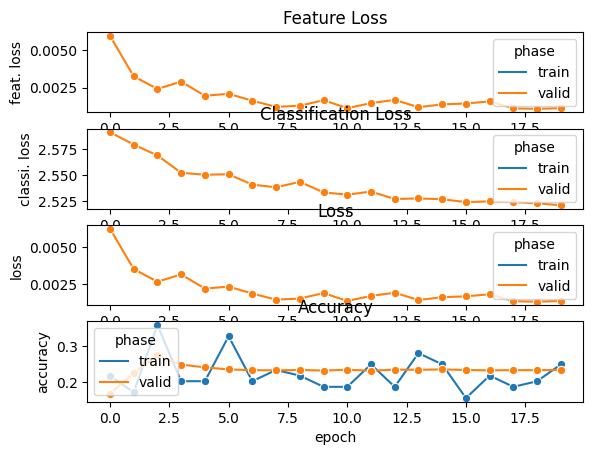

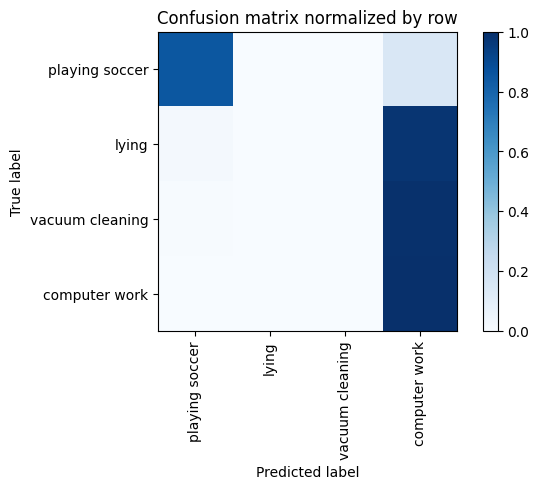

Overall accuracy: 0.486

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.460      1.000      0.630      0.432       3068|	 vacuum cleaning: 0.000,	lying: 0.000,	
          lying       0.000      0.000      0.000      0.264       1877|	 computer work: 0.979,	playing soccer: 0.021,	vacuum cleaning: 0.000,	
vacuum cleaning       0.000      0.000      0.000      0.240       1704|	 computer work: 0.994,	playing soccer: 0.006,	
 playing soccer       0.886      0.851      0.868      0.064        455|	 computer work: 0.149,	vacuum cleaning: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.255      0.486      0.328        1.0       7104|	      

{'accuracy': 0.48634572072072074, 'precision': 0.3364401287944756, 'recall': 0.46263736263736266, 'f1': 0.3745040086968338, 'samples': 7104, 'loss': 627.0400876998901, 'feat. loss': 626.1510758399963, 'c

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.192



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.194



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.193



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.163



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.175



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.167



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.165



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.168



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.167



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.168



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.162



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.168



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.175



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.201



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.269



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.245



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.272



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.257



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.272



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.285



unseen:   0%|          | 0/68 [00:00<?, ?batch/s]

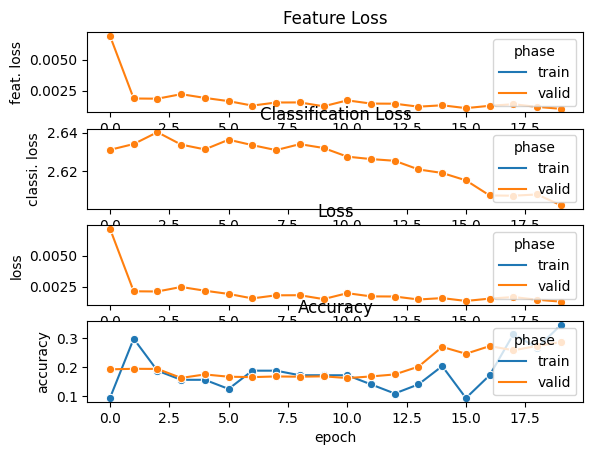

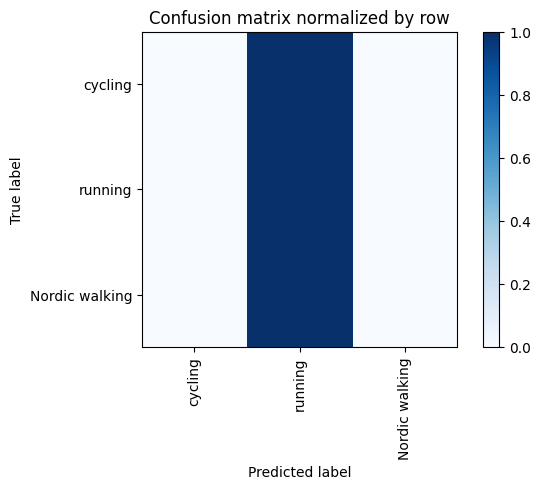

Overall accuracy: 0.216

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.000      0.000      0.000      0.418       1818|	 running: 1.000,	cycling: 0.000,	
       cycling       0.000      0.000      0.000      0.366       1592|	 running: 1.000,	Nordic walking: 0.000,	
       running       0.216      1.000      0.356      0.216        942|	 Nordic walking: 0.000,	cycling: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.047      0.216      0.077        1.0       4352|	      

{'accuracy': 0.21645220588235295, 'precision': 0.07215073529411765, 'recall': 0.3333333333333333, 'f1': 0.11862485833018512, 'samples': 4352, 'loss': 499.9910991191864, 'feat. loss': 499.48515796661377, 'classi. loss': 5059.397178649902, 'N': 3}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.228



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.263



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.272



train:   0%|          | 0/319 [00:00<?, ?batch/s]

In [ ]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['seq_len'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-6)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.TripletMarginLoss(margin=0.5, p=1, reduction='none')}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=config['class_alpha'])
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=config['class_alpha'], print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'eval', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=config['class_alpha'], print_report=True, show_plot=True)
    test_metrics['N'] = len(unseen_classes)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
weighted_score_df = seen_score_df[["accuracy", "precision", "recall", "f1"]].multiply(seen_score_df["N"], axis="index")
final_results = weighted_score_df.sum()/seen_score_df['N'].sum()
print(final_results)
log('global', '',final_results.to_dict())
run.stop()
